# Tutorial: Dimension adaptive forward uncertainty propagation with EasyVVUQ

Here we will use EasyVVUQ to perform sparse grid forward uncertainty quantification on a relatively cheap, yet high-dimensional model.

**Note**: if you installed EasyVVUQ using a virtual environment, make sure that:

1) you activated the virtual environment, and
2) you started this notebook with `myenv/bin/jupyterlab`.

## Sparse grid UQ on an HIV model

Here we will look at a HIV model [1], taken from the [Active Subspace data set repository](https://github.com/paulcon/as-data-sets). It models the T-cell count over time (days), and has **27 input parameters spread out over 7 coupled ODEs.**

### HIV model

From [here](https://github.com/paulcon/as-data-sets/blob/master/HIV/HIV.ipynb) we find the following description of the model, see also [4]. The 7 coupled ordinary differential equations are given by:

$$
\begin{align}
\frac{dT}{dt} &= s_1 + \frac{p_1}{C_1+V}TV - \delta_1T - (K_1V + K_2M_I)T,\\
\frac{dT_I}{dt} &= \psi(K_1V + K_2M_I)T + \alpha_1T_L-\delta_2T_I-K_3T_ICTL,\\
\frac{dT_L}{dt} &= (1-\psi)(K_1V+K_2M_I)T-\alpha_1T_L-\delta_3T_L,\\
\frac{dM}{dt} &= s_2+K_4MV-K_5MV-\delta_4M,\\
\frac{dM_I}{dt} &= K_5MV-\delta_5M_I-K_6M_ICTL,\\
\frac{dCTL}{dt} &= s_3 + (K_7T_I+K_8M_I)CTL-\delta_6CTL,\\
\frac{dV}{dt} &= K_9T_I+K_{10}M_I-K_{11}TV-(K_{12}+K_{13})MV-\delta_7V,
\end{align}
$$

where $T(t)$ is the CD4$^+$ T-cell population, $T_I$ is the actively infected T-cell population, $T_L$ represents latently-infected T-cells, $M$ is macrophages, $M_I$ is infected macrophages, $CTL$ is cytotoxic lymphocytes, and $V$ is virions. The model's 27 parameters are summarized in the table below.

Parameter|Nominal Value|Distribution (U(min, max))
:-------:|:-----------:|:-------------:
$s_1$|  10 |  U(9.75, 10.25)
$s_2$|   .15 |  U(.14625, .15375)
$s_3$|   5  | U(4.875, 5.125)
$p_1$|   .2 |  U(.195, .205)
$C_1$|   55.6  | U(54.21, 56.99)
$K_1$|   3.87e-3 |  U(3.77325e-3, 3.96675e-3)
$K_2$|   1e-6  | U(.975e-6, 1.025e-6)
$K_3$|   4.5e-4 |  U(4.3875e-4, 4.6125e-4)
$K_4$|   7.45e-4 |  U(7.26375e-4, 7.63625e-4)
$K_5$|   5.22e-4 |  U(5.0895e-4, 5.3505e-4)
$K_6$|   3e-6  | U(2.925e-6, 3.075e-6)
$K_7$|   3.3e-4  | U(3.2175e-4, 3.3825e-4)
$K_8$|   6e-9  | U(5.85e-9, 6.15e-9)
$K_9$|   .537 |  U(.523575, .550425)
$K_{10}$|   .285 |  U(.277875, .292125)
$K_{11}$|   7.79e-6 |  U(7.59525e-6, 7.98475e-6)
$K_{12}$|   1e-6  | U(.975e-6, 1.025e-6)
$K_{13}$|   4e-5   |U(3.9e-5, 4.1e-5)
$\delta_1$|   .01 |  U(.00975, .01025)
$\delta_2$|   .28  | U(.273, .287)
$\delta_3$|   .05  | U(.04875, .05125)
$\delta_4$|   .005  | U(.004875, .005125)
$\delta_5$|   .005 |  U(.004875, .005125)
$\delta_6$|   .015 |  U(.014625, .015375)
$\delta_7$|   2.39 |  U(2.33025, 2.44975)
$\alpha_1$|   3e-4 |  U(2.925e-4, 3.075e-4)
$\psi$|   .97 |  U(.94575, .99425)

The limits on the **uniform distributions are 2.5% above and below the nominal values**. 


In [1]:
import os
import numpy as np
import easyvvuq as uq
import chaospy as cp
import matplotlib.pyplot as plt
from easyvvuq.actions import CreateRunDirectory, Encode, Decode, ExecuteLocal, Actions

### Setting up an EasyVVUQ campaign

The fist couple of steps in a sparse grid campaign are no different than in the previous tutorial on the advection-diffusion model.

We first set up the `params` dictionary, in which we specify the name, type and default value of each input:

In [2]:
# default values
nominal = np.array([10, .15, 5, .2, 55.6, 3.87e-3, 1e-6, 4.5e-4, 7.45e-4, 5.22e-4, 3e-6,\
    3.3e-4, 6e-9, .537, .285, 7.79e-6, 1e-6, 4e-5, .01, .28, .05, .005, .005, .015, 2.39,\
    3e-4, .97])

# parameter names
param_names = ['s_1', 's_2', 's_3', 'p_1', 'C_1', 'K_1', 'K_2', 'K_3', 'K_4', 'K_5', 'K_6',
               'K_7', 'K_8', 'K_9', 'K_10', 'K_11', 'K_12', 'K_13', 'delta_1', 'delta_2', 'delta_3',
               'delta_4', 'delta_5', 'delta_6', 'delta_7', 'alpha_1', 'psi']
# params dict
params = {}
for idx, name in enumerate(param_names):
    params[name] = {'type': 'float', 'default': nominal[idx]}

params

{'s_1': {'type': 'float', 'default': 10.0},
 's_2': {'type': 'float', 'default': 0.15},
 's_3': {'type': 'float', 'default': 5.0},
 'p_1': {'type': 'float', 'default': 0.2},
 'C_1': {'type': 'float', 'default': 55.6},
 'K_1': {'type': 'float', 'default': 0.00387},
 'K_2': {'type': 'float', 'default': 1e-06},
 'K_3': {'type': 'float', 'default': 0.00045},
 'K_4': {'type': 'float', 'default': 0.000745},
 'K_5': {'type': 'float', 'default': 0.000522},
 'K_6': {'type': 'float', 'default': 3e-06},
 'K_7': {'type': 'float', 'default': 0.00033},
 'K_8': {'type': 'float', 'default': 6e-09},
 'K_9': {'type': 'float', 'default': 0.537},
 'K_10': {'type': 'float', 'default': 0.285},
 'K_11': {'type': 'float', 'default': 7.79e-06},
 'K_12': {'type': 'float', 'default': 1e-06},
 'K_13': {'type': 'float', 'default': 4e-05},
 'delta_1': {'type': 'float', 'default': 0.01},
 'delta_2': {'type': 'float', 'default': 0.28},
 'delta_3': {'type': 'float', 'default': 0.05},
 'delta_4': {'type': 'float', 'def

Next we'll set up the **encoder**, which will create the input files for the HIV model using an input template. In this case the input file is just a comma-separated file of values. To create an EasyVVUQ input template each value is replaced by `$param_name`:

`$s_1,$s_2,$s_3,$p_1,$C_1,$K_1,$K_2,$K_3,$K_4,$K_5,$K_6,$K_7,$K_8,$K_9,$K_10,$K_11,$K_12,$K_13,$delta_1,$delta_2,$delta_3,$delta_4,$delta_5,$delta_6,$delta_7,$alpha_1,$psi`

The encoder will swap out the `$param_name` flags for values drawn from the specified input distribution.

In [3]:
# input file encoder
encoder = uq.encoders.GenericEncoder(template_fname='HIV_model/HIV.template', delimiter='$', target_filename='input.csv')

The HIV model writes a CSV file containing the predicted T-cell count. The **decoder** will read this file and store its contents within the EasyVVUQ database. 

In [4]:
# Quantity of Interest, also the column name of the output CSV file
QOI = 'T_cell_count'
# CSV output file decoder
decoder = uq.decoders.SimpleCSV(target_filename='output.csv', output_columns=[QOI])

We'll run the HIV ensemble locally. However, in many cases of practical interest the model will be too expensive for local execution. In this case the VECMA tools [QCG-PilotJob](https://github.com/vecma-project/QCG-PilotJob) or [FabSim3](https://github.com/djgroen/FabSim3) can be used in combination with EasyVVUQ to submit the ensemble to HPC resources.

In [5]:
# local execution of HIV_model.py
execute = ExecuteLocal('python {}/HIV_model/HIV_model.py'.format(os.getcwd()))

Now we are combine all actions we want to execute into an `Actions` object.

In [6]:
# location where the run directories are stored
WORK_DIR = '/tmp'
# actions to be undertaken: make rundirs, encode input files, execute local model ensemble, decode output files
actions = Actions(CreateRunDirectory(root=WORK_DIR, flatten=True), Encode(encoder), execute, Decode(decoder))

The central object in the UQ analysis is a so-called Campaign. This is created as:

In [7]:
campaign = uq.Campaign(name='HIV_SC', work_dir=WORK_DIR, params=params, actions=actions)

### Input specification

Next we specify a probability density functions input parameter in the `vary` dict. Here we'll just include 2 inputs to visualize the full sampling plan, and specify a uniform input distribution with bounds at $\pm 2.5 \%$ from their default value.

**Assignment** Create a `vary` dict for `K_4` and `delta_7` with the mentioned input distributions. Note that the nominal values are stored in `nominal`.

**Question**: what will the encoder do with the other 25 inputs?

In [8]:
vary = {}


{'K_4': Uniform(lower=0.000726375, upper=0.000763625),
 'delta_7': Uniform(lower=2.33025, upper=2.44975)}

### Isotropic sparse-grid sampler

This is where we deviate from the previous tutorial. We will first make an isotropic sparse grid sampler, i.e. one that:

* is more sparse than the standard `uq.sampling.SCSampler`, yet
* still treats each input in the same manner.

To generate the sampling plan we select the (sparse) Stochastic Collocation sampler. 

**Assignment**: Create a `uq.sampling.SCSampler` object with the following properties:

* `sparse=True`: speaks for itself
* `polynomial_order=1`: in the case of `sparse=True`, this is an overloaded term. By setting `polynomial_order=1` we are essentially starting with 1 code sample, i.e. $\Lambda=\{(0,0)\}$ as a multi indiex set.
* `quadrature_rule='C'`: select the Clenshaw Curtis (CC) quadrature rule
* `growth=True`: selects an exponential growth rule, making CC **nested**. This is *not* possible for every quadrature rule, see [Chaospy documentation](https://chaospy.readthedocs.io/en/master/reference/quadrature/index.html).

Don't forget to attach the sampler to the campaign with `campaign.set_sampler`.

In [9]:
sampler = 

Below is just a subroutine to plot a 2D sampling plan

In [10]:
def plot_sampling_plan(sampler):
    """
    Plot the sampling plan of the (first) two input dimensions
    """
    fig = plt.figure()
    
    ax = fig.add_subplot(111, xlabel='x_1', ylabel='x_2')
    # the xi_d array contains the N x d sampling points, with N being the number of points and d the number of inputs
    ax.plot(sampler.xi_d[:,0], sampler.xi_d[:, 1], 'ro')
    # print the number of points to screen
    print("Number of sampling points = %d" % sampler.n_samples)

This is a subroutine for plotting a 2 or 3 dimensional multi index set:

In [11]:
def plot_multi_idx(multi_idx, c='lightgray', fill = False, lbl = "", alpha=0.8, **kwargs):
    """
    Visualize a 2D or 3D multi index set.

    Parameters
    ----------
    ax : matplotlib axis
        The axis to plot on.
    multi_idx : array
        The array of multi indices.
    c : string, optional
        Color. The default is 'lightgray'.
    fill : boolean
        Fill the squares. if multi index is 2D. Default is False.
    lbl : string
        A label for the filled squares. Default = ""
    alpha : float
        Makes the 3D voxels opague by lowering alpha. Default is 0.8.

    Returns
    -------
    None.

    """
    fig = plt.figure()

    d = multi_idx[0].size

    if d == 2:

        ax = fig.add_subplot(111)
        
        ax.set_xticks(np.arange(6))
        ax.set_yticks(np.arange(6))
        ax.set_xlabel(r'$l_1$', fontsize=18)
        ax.set_ylabel(r'$l_2$', fontsize=18, rotation=0)

        for idx in multi_idx:
            idx0 = idx[0]; idx1 = idx[1]
            # plot midpoint
            if not fill:
                if 'mid_point' in kwargs:
                    ax.text(idx0, idx1, '%s' % kwargs['mid_point'][tuple(idx)], 
                            horizontalalignment='center', verticalalignment='center')
                else:
                    ax.plot(idx0, idx1, 'x', color=c, label=r'${\bf l}\in\Lambda$')

            # plot single square
            ax.plot([idx0 - 0.5, idx0 + 0.5], [idx1 - 0.5, idx1 - 0.5], color=c)
            ax.plot([idx0 + 0.5, idx0 + 0.5], [idx1 - 0.5, idx1 + 0.5], color=c)
            ax.plot([idx0 + 0.5, idx0 - 0.5], [idx1 + 0.5, idx1 + 0.5], color=c)
            ax.plot([idx0 - 0.5, idx0 - 0.5], [idx1 + 0.5, idx1 - 0.5], color=c)

            if fill:
                ax.fill([idx0 - 0.5, idx0 + 0.5, idx0 + 0.5, idx0 + 0.5, idx0 + 0.5, idx0 + 0.5, idx0 - 0.5, idx0 - 0.5],
                        [idx1 - 0.5, idx1 - 0.5, idx1 - 0.5, idx1 + 0.5, idx1 + 0.5, idx1 + 0.5, idx1 + 0.5, idx1 - 0.5],
                        color=c, label=lbl)

        plt.axis('scaled')
        plt.xlim([-0.5, 5.5])
        plt.ylim([-0.5, 5.5])
        plt.tight_layout()

    elif d == 3:

        ax = fig.add_subplot(111, projection='3d')
        
        ax.set_xticks(np.arange(6) + 0.5)
        ax.set_xticklabels(np.arange(6))
        ax.set_yticks(np.arange(6) + 0.5)
        ax.set_yticklabels(np.arange(6))
        ax.set_zticks(np.arange(6) + 0.5)
        ax.set_zticklabels(np.arange(6))
        
        ax.set_xlabel(r'$i_1$', fontsize=18)
        ax.set_ylabel(r'$i_2$', fontsize=18)
        ax.set_zlabel(r'$i_3$', fontsize=18)
        
        ax.view_init(elev=30, azim=45)
        
        # Remove colored axes planes
        ax.xaxis.pane.fill = False
        ax.yaxis.pane.fill = False
        ax.zaxis.pane.fill = False
        
        # Set color to white 
        ax.xaxis.pane.set_edgecolor('w')
        ax.yaxis.pane.set_edgecolor('w')
        ax.zaxis.pane.set_edgecolor('w')

        # create 6 layers of 6 x 6 voxels
        N = np.max(multi_idx) + 1
        voxels = np.zeros([N,N,N], dtype=bool)
        for idx in multi_idx:
            # set to True to display voxel
            voxels[idx[0], idx[1], idx[2]] = True

        #plot cubes
        ax.voxels(voxels, facecolors=c, edgecolor='k', alpha=alpha)


Plot the initial sampling plan

Number of sampling points = 1


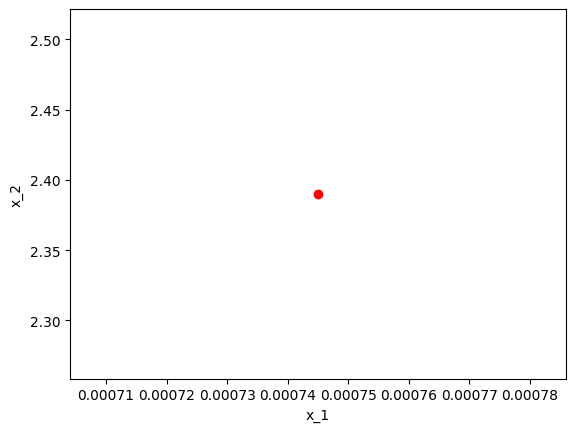

In [12]:
plot_sampling_plan(sampler)

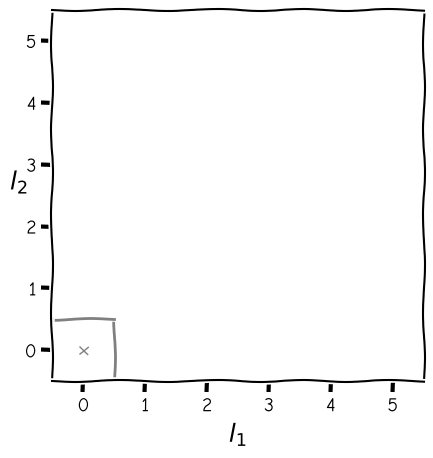

In [13]:
# if you do not like the cartoony feel of the plot, remove "with plt.xkcd():"
with plt.xkcd():   
    plot_multi_idx(sampler.l_norm - 1, c='gray') 

We can refine the grid to the next isotropic level via `sampler.next_level_sparse_grid()`.

**Assigment**: 

* refine the sparse-grid once, and plot the grid and the multi index set using the subroutines above. Remember that to actually execute the ensembles you must run `campaign.execute().collate(progress_bar=True)`.
* Next, perform an analysis step, and plot the first order Sobol indices. These are vector-valued in time, each entry represent 1 day. Which input is dominant?
* Also plot the sum of the first-order indices. What do you see?
* Refine the grid once more (just execute the cell with your `next_level_sparse_grid` again). Replot the Sobol indices. Can you explain the change in the sum of the first-order indices?
* Refine the grid 3 more times. How many points do you get in the end?

Number of sampling points = 5


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.15it/s]


<Figure size 640x480 with 0 Axes>

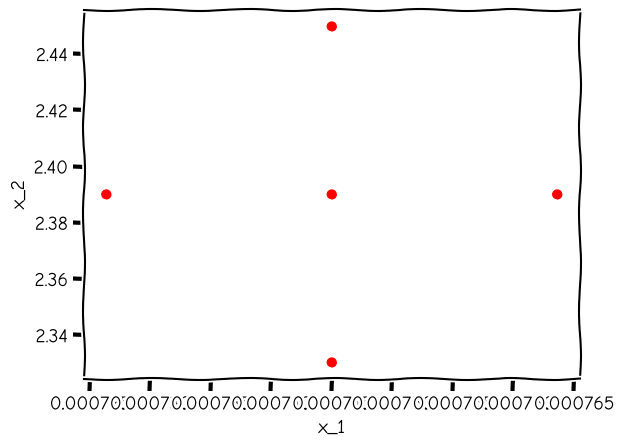

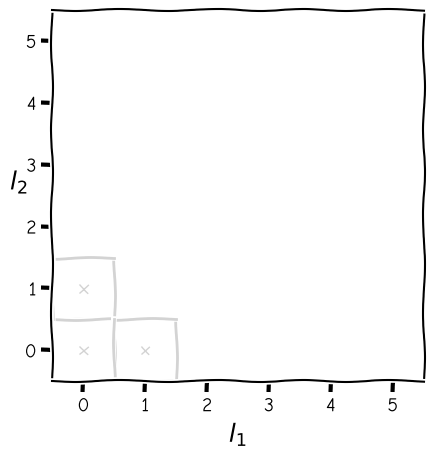

In [14]:
n_adaptations = 1
for i in range(n_adaptations):


In [15]:
results = campaign.analyse(qoi_cols=[QOI])

In [ ]:
sobols_first = 

## Dimension-adaptive sparse grids

The sparse grids shown above are **isotropic**, in the sense that both inputs are treated the same. While isotropic sparse grids contains less points compared to the standard SC method, they will not scale very well when we have 27 inputs. 

In this case we can opt to apply the dimension-adaptive version of the SC sampler, in order to create an **anisotropic** sparse grid. This process is iterative in nature, usually staring from a single point. Unlike the isotropic case, only a certain (combination of) parameters will get refined. 

At each iteration, the code is evaluated at certain (so-called *admissible*) refinements, the `x` symbols in the cartoon below. Refinement means adding another tensor product where the quadrature order of one or more inputs is increased by one. Only one of the admissible refinements will get accepted, creating an anisotropic sampling plan.

![](images/adapt.png)

To determine which of the admissible refinement gets accepted, an error measure is computed for every refinement. The one with the highest error is accepted. Here we will use *hierarchical surplus*, as explained in the class. 

We will create a new campaign, the `params` dict and the `actions` do not need to redefined.

In [17]:
campaign = uq.Campaign(name='HIV_SC_adaptive', params=params, actions=actions, work_dir='/tmp')

**Assignment**: redefine `vary`, include all 27 inputs at with Uniform distributions at $\pm$ 2.5 percent of the values in `nominal`.

In [18]:
vary = {}


{'s_1': Uniform(lower=9.75, upper=10.25),
 's_2': Uniform(lower=0.14625, upper=0.15374999999999997),
 's_3': Uniform(lower=4.875, upper=5.125),
 'p_1': Uniform(lower=0.195, upper=0.205),
 'C_1': Uniform(lower=54.21, upper=56.989999999999995),
 'K_1': Uniform(lower=0.00377325, upper=0.00396675),
 'K_2': Uniform(lower=9.75e-07, upper=1.025e-06),
 'K_3': Uniform(lower=0.00043874999999999996, upper=0.00046124999999999996),
 'K_4': Uniform(lower=0.000726375, upper=0.000763625),
 'K_5': Uniform(lower=0.00050895, upper=0.0005350499999999999),
 'K_6': Uniform(lower=2.925e-06, upper=3.0749999999999998e-06),
 'K_7': Uniform(lower=0.00032175, upper=0.00033824999999999995),
 'K_8': Uniform(lower=5.8499999999999994e-09, upper=6.15e-09),
 'K_9': Uniform(lower=0.523575, upper=0.5504249999999999),
 'K_10': Uniform(lower=0.277875, upper=0.29212499999999997),
 'K_11': Uniform(lower=7.59525e-06, upper=7.98475e-06),
 'K_12': Uniform(lower=9.75e-07, upper=1.025e-06),
 'K_13': Uniform(lower=3.9e-05, upper=4

**Assigment**: make a new sparse-grid SC sampler, except this time also add the keyword `dimension_adaptive = True`. Add the sampler to the campaign and execute the ensemble.

In [19]:
sampler = 

To analyse the results (and execute the dimension adaptivity), we need a separate `SCAnalysis` object:

In [21]:
analysis = uq.analysis.SCAnalysis(sampler=sampler, qoi_cols=[QOI])
# perform analysis (basically estimates moments, Sobol analysis, and updates internal state of analysis)
campaign.apply_analysis(analysis)

/home/wouter/py-env/lib/python3.9/site-packages/easyvvuq/analysis/sc_analysis.py:1128: RuntimeWarning: invalid value encountered in divide
  S_u[u] = D_u[u] / D


We are now at the starting point of a dimension-adaptive campaign of a 27-dimensional input space, with an ensemble consisting of just a single code sample. In other words, the accepted index set is $\Lambda\{(0,0,0,....,0)\}$. This is stored in the (not very well named) `analysis.l_norm` array:

In [22]:
# Lambda (starts counting at 1 instead of 0, so this is equivalent to (0,0,0,...,0))
analysis.l_norm

array([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1]])

Now we'll refine the grid several times in an anisotropic fashion, placing samples only in the most important input directions. A single refinement step consists of the following sequence:

* `sampler.look_ahead(multi indices)`: this determines the new admissible candidate multi-indices (the new admissible forward neighbours). It take the current multi index set as an arugument (what was called $\Lambda$ in the class). Remember this is stored in the `analysis.l_norm` array.
*  Execute the ensemble in the usual way
* `campaign.get_collation_result()`: get the Pandas data frame with all up-to-date code samples.
* `adapt_dimension(QOI, data_frame)`: computes the hierarchical surplus at all candidate refinements, and accepts the one with the highest surplus.

**Assigment**: make a loop of these steps that refines the grid a specified number of times.

In [23]:
number_of_adaptations = 30
for i in range(number_of_adaptations):


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.83it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:00<00:00, 13.41it/s]
0it [00:00, ?it/s]
100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:01<00:00, 14.50it/s]
0it [00:00, ?it/s]
100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:00<00:00, 14.83it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████

This command retrieves the result after all refinements:

In [24]:
results = campaign.get_last_analysis()

**Assignment**: examine the ensemble sizes of each iteration. These are stored in `sampler.n_new_points`. Explain what you see. What is the smalles enemble size. Can you explain it?

Still, at every iteration one multi index is added to $\Lambda$. 

The `adaptation_table` shows a plot of that visualizes which inputs got refined. Again, each refinement is another tensor product of 1D quadrature points, where the quadrature order of at least 1 input is increased. Note that the algorithm will focus on a subset of inputs.

In [26]:
    def adaptation_table(vary, multi_idx, **kwargs):
        """Plots a color-coded table of the quadrature-order refinement.
        Shows in what order the parameters were refined, and unlike
        adaptation_histogram, this also shows higher-order refinements.

        Parameters
        ----------
        **kwargs: can contain kwarg 'order' to specify the order in which
        the variables on the x axis are plotted (e.g. in order of decreasing
        1st order Sobol index).

        Returns
        -------
        None.

        """

        D = multi_idx[0].size
        
        # if specified, plot the variables on the x axis in a given order
        if 'order' in kwargs:
            order = kwargs['order']
        else:
            order = range(D)

        l = np.copy(multi_idx)[:, order]
        import matplotlib as mpl
        import matplotlib.pyplot as plt

        fig = plt.figure(figsize=[12, 6])
        ax = fig.add_subplot(111)

        # max quad order
        M = np.max(l)
        cmap = plt.get_cmap('Purples', M)
        # plot 'heat map' of refinement
        plt.imshow(l.T, cmap=cmap, aspect='auto')
        norm = mpl.colors.Normalize(vmin=0, vmax=M - 1)
        sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
        sm.set_array([])
        # cb = plt.colorbar(sm, cax=ax)
        # plot the quad order in the middle of the colorbar intervals
        p = np.linspace(0, M - 1, M + 1)
        tick_p = 0.5 * (p[1:] + p[0:-1])
        # cb.set_ticks(tick_p)
        # cb.set_ticklabels(np.arange(M))
        # cb.set_label(r'quadrature order')
        # plot the variables names on the x axis
        ax.set_yticks(range(l.shape[1]))
        params = np.array([key for key in vary.keys()])
        ax.set_yticklabels(params[order], fontsize=12)
        # ax.set_yticks(range(l.shape[0]))
        ax.set_xlabel('iteration')
        # plt.yticks(rotation=90)
        plt.tight_layout()
        plt.show()

**Assignment** Run this command below, to visualize the refinement process. Different colors represent different quadrature orders of the entries of the accepted multi indices. What happens from iteration 0 onward? Would you say there is an low effective dimension, despite having a 27 dimensional space? Make sure you've executed enough interations to confidently answer this question. 

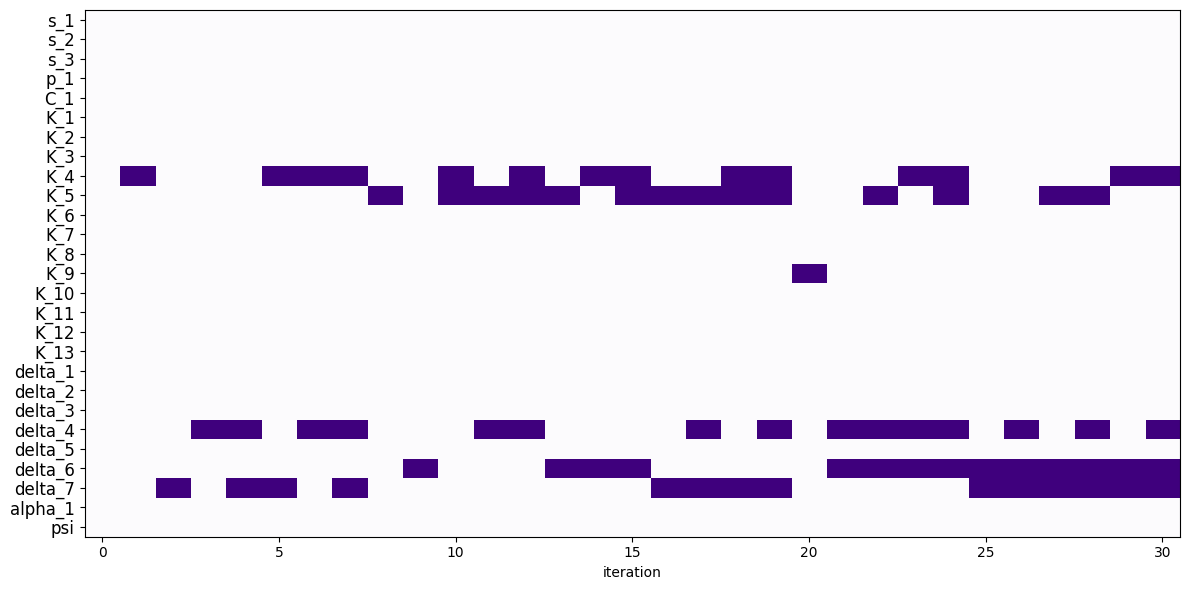

In [27]:
adaptation_table(vary, analysis.l_norm)

Here we will compute confidence intervals:

In [28]:
def get_confidence_intervals(samples, conf=0.9):
    """
    Compute the confidence intervals given an array of samples

    Parameters
    ----------
    samples : array
        Samples on which to compute the intervals.
    conf : float, optional, must be in [0, 1].
        The confidence interval percentage. The default is 0.9.

    Returns
    -------
    lower : array
        The lower confidence bound..
    upper : array
        The upper confidence bound.

    """

    # ake sure conf is in [0, 1]
    if conf < 0.0 or conf > 1.0:
        print('conf must be specified within [0, 1]')
        return

    # lower bound = alpha, upper bound = 1 - alpha
    alpha = 0.5 * (1.0 - conf)

    # arrays for lower and upper bound of the interval
    n_samples = samples.shape[0]
    N_qoi = samples.shape[1]
    lower = np.zeros(N_qoi)
    upper = np.zeros(N_qoi)

    # the probabilities of the ecdf
    prob = np.linspace(0, 1, n_samples)
    # the closest locations in prob that correspond to the interval bounds
    idx0 = np.where(prob <= alpha)[0][-1]
    idx1 = np.where(prob <= 1.0 - alpha)[0][-1]

    # for every location of qoi compute the ecdf-based confidence interval
    for i in range(N_qoi):
        # the sorted surrogate samples at the current location
        samples_sorted = np.sort(samples[:, i])
        # the corresponding confidence interval
        lower[i] = samples_sorted[idx0]
        upper[i] = samples_sorted[idx1]

    return lower, upper

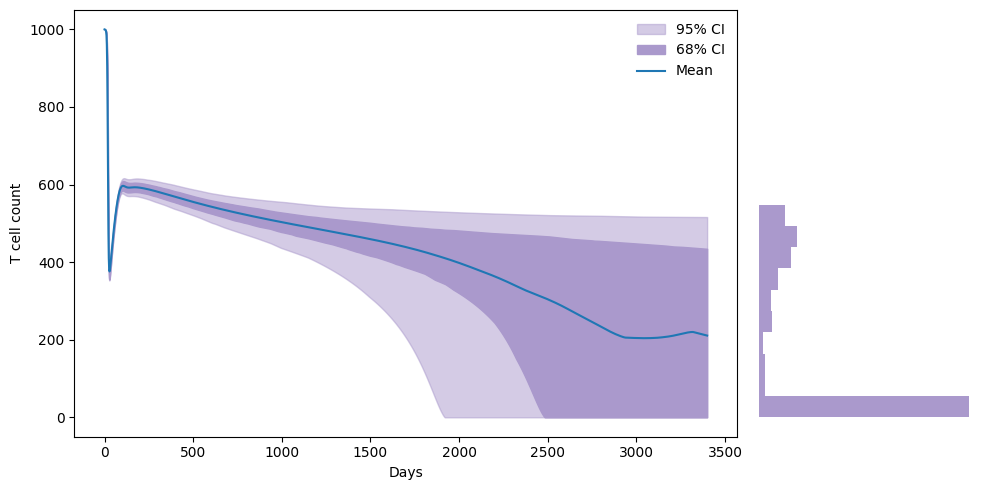

In [29]:
from matplotlib import gridspec

x = range(analysis.N_qoi[QOI])

code_samples = analysis.get_sample_array(QOI)
n_samples = code_samples.shape[0]

#confidence bounds
lower1, upper1 = get_confidence_intervals(code_samples, conf=0.63)
lower2, upper2 = get_confidence_intervals(code_samples, conf=0.95)

fig = plt.figure(figsize=(10,5))
spec = gridspec.GridSpec(ncols=2, nrows=1,
                          width_ratios=[3, 1])

ax1 = fig.add_subplot(spec[0])
ax2 = fig.add_subplot(spec[1], sharey=ax1)
ax2.get_xaxis().set_ticks([])
fig.subplots_adjust(wspace=0)
plt.setp(ax2.get_yticklabels(), visible=False)

ax1.fill_between(x, lower2, upper2, color='#aa99cc', label='95% CI', alpha=0.5)
ax1.fill_between(x, lower1, upper1, color='#aa99cc', label='68% CI')

mean = results.describe(QOI, 'mean')
ax1.plot(x, mean, label='Mean')

ax1.legend(loc=0, frameon=False)

ax1.set_xlabel('Days')
ax1.set_ylabel('T cell count')
ax2.axis('off')
ax2.hist(code_samples[:, -1], orientation='horizontal', color='#aa99cc')

plt.tight_layout()

Finally, we will create a plot with all first-order Sobol indices `S_i`, which shows the fraction of the output variance (vs time here), that each input variable is responsible for *by itself*. To also estimate higher-order effects (the fraction of variance obtained by simultaneously varying 2 or more inputs together), we sum all first-order indices. Where this sum is close to one, there is (almost) no higher-order effect.

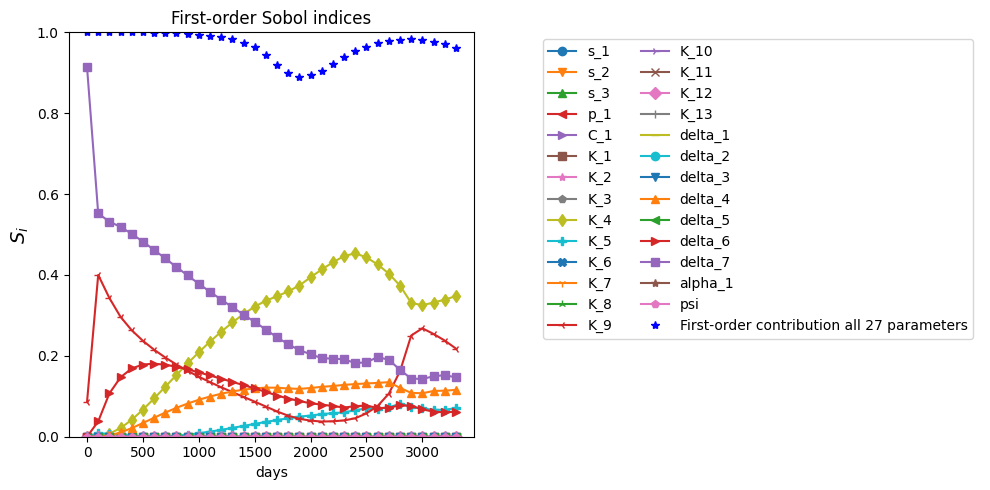

In [30]:
from itertools import cycle

# color = cycle(['b', 'r', 'g', 'm', 'c', 'k'])
marker = cycle(['o', 'v', '^', '<', '>', 's', '*', 'p', 'd', 'P', 'X', 
                '1', '2', '3', '4', 'x', 'D', '|', '_'])
skip = 100
x = range(0, analysis.N_qoi[QOI], skip)

fig = plt.figure(figsize=[10, 5])
ax = fig.add_subplot(121, title=r'First-order Sobol indices',
                      xlabel="days", ylim=[0,1])
ax.set_ylabel(r'$S_i$', fontsize=14)
sobols_first = results.sobols_first(QOI)

first_order_contribution = 0

for param in sobols_first.keys():
    ax.plot(x, sobols_first[param][0:-1:skip], label=param, marker=next(marker))
    first_order_contribution += sobols_first[param][0:-1:skip]
    
ax.plot(x, first_order_contribution, 'b*', label=r'First-order contribution all 27 parameters')

# place legend on empty axes on the right
handles, labels = ax.get_legend_handles_labels()    # ax1 legend
ax2 = fig.add_subplot(122)                          # ax2
ax2.axis('off')                                     # make ax2 empty
ax2.legend(handles, labels, ncol=2)                 # place ax1 legend on ax1
plt.tight_layout()

## References

[1] T. Loudon and S. Pankavich. _Mathematical Analysis and Dynamic Active Subspaces for a Long term model of HIV_. arXiv:1604.04588, 2016